# Relaxed Data Challenge

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [202]:
# load dataset

users = pd.read_csv('takehome_users.csv',encoding='latin-1')
engagement = pd.read_csv('takehome_user_engagement.csv',encoding='latin-1')

In [203]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [204]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [205]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [206]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [207]:
# change the time format

users.creation_time = pd.to_datetime(users.creation_time)
users.last_session_creation_time = pd.to_datetime(users.last_session_creation_time)
engagement.time_stamp = pd.to_datetime(engagement.time_stamp)

In [208]:
# Store the length of time that users have been active (last_session_creation_time - creation_source)

users = users.assign(length=(users.last_session_creation_time - users.creation_time).astype('timedelta64'))

# The user without last_session_creation_time last never use the software, fill them with 0
users.length.fillna(0, inplace=True)

In [209]:
# group email information by email domain

users = users.assign(email_domain = users.email.str.split('@').str[1])

# check how many email domains
users.email_domain.value_counts()

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
xvnbr.com            2
luque.com            2
qgjbc.com            2
xybhi.com            2
rerwl.com            2
mumdc.com            2
oqpze.com            2
dqwln.com            2
hgiyt.com            1
hdtlb.com            1
jhiss.com            1
breuo.com            1
kqdqv.com            1
aqdqw.com            1
bsjsm.com            1
ksmgt.com            1
fqqhl.com            1
jjsoq.com            1
arhlj.com            1
rhkdk.com            1
iiqgf.com            1
yjysq.com            1
nwulu.com            1
xdsil.com            1
                  ... 
iaery.com            1
ucxjb.com            1
slcce.com            1
tlxgl.com            1
mccbx.com            1
korrl.com            1
xmqro.com            1
oebvz.com            1
qqgix.com            1
tmbux.com            1
ijvcz.com            1
mzkem.com            1
ysvxe.com  

In [210]:
# clean the email_domain, the rare email domail will be filled with others

major_email = users.email_domain.value_counts()[0:6]
users.email_domain = [i if i in major_email else 'other' for i in users.email_domain]

In [211]:
#clean up invited_by_user_id, 1- invited by users, 0 - not invited by users
#create a column of whether invited by user
users['invited_by_user'] = ""

#fill missing value of invited_by_user_id with 0
users['invited_by_user_id'].fillna(0,inplace=True)

users['invited_by_user'] = [i if i == 0 else 1 for i in users.invited_by_user_id]

In [212]:
engagement.set_index('time_stamp',inplace=True)

In [213]:
# set function to determine if user is adopted

users['adopted'] ='' # add adapted_user column

def user_adopted(id): # define a function to determine user is adopted or not and save to users

    selected = engagement.loc[engagement.user_id == id]  #slice record of single user
    selected.resample('D').mean().dropna()  #group record of same day, to ensure no duplicate login per day
    adopted = 0 # set variable =0
    
    for index in range(len(selected)-2):
         
        #user who has logged into the product on three separate days in at least one seven day period
        if selected.index[index + 2] - selected.index[index] <= pd.Timedelta('7D'): # 3 times of user login within 7 days
            adopted = 1 # mark 1 when user is adopted
            break
        else:
            adopted = 0; #mark 0 when user is not adopted
        
    return adopted

In [214]:
# apply user_Adopted function to users dataframe

users['adopted'] = users['object_id'].apply(user_adopted)

In [215]:
users.adopted.value_counts()

0    10344
1     1656
Name: adopted, dtype: int64

It is a unbalanced dataset. 

In [216]:
# Drop unrelated columns
users_feature = users.drop(['object_id','creation_time','name','email','last_session_creation_time',
                            'invited_by_user_id'],1)

In [217]:
# get dummy variables for category data

users_feature = pd.get_dummies(users_feature, columns = ['creation_source', 'email_domain'])

In [218]:
users_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 18 columns):
opted_in_to_mailing_list              12000 non-null int64
enabled_for_marketing_drip            12000 non-null int64
org_id                                12000 non-null int64
length                                12000 non-null float64
invited_by_user                       12000 non-null float64
adopted                               12000 non-null int64
creation_source_GUEST_INVITE          12000 non-null uint8
creation_source_ORG_INVITE            12000 non-null uint8
creation_source_PERSONAL_PROJECTS     12000 non-null uint8
creation_source_SIGNUP                12000 non-null uint8
creation_source_SIGNUP_GOOGLE_AUTH    12000 non-null uint8
email_domain_cuvox.de                 12000 non-null uint8
email_domain_gmail.com                12000 non-null uint8
email_domain_gustr.com                12000 non-null uint8
email_domain_hotmail.com              12000 non-null uint8
em

It is a small dataset but highly unbalanced. I choose Random Forest model to predict the user adoption. 

In [230]:
# Split data into train set and test set
from sklearn.model_selection import train_test_split

X = users_feature.drop(['adopted'],1)
y = users_feature.adopted

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=21,stratify=y)

In [231]:
# Train and fit random forest model

from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(bootstrap=True, criterion = 'gini', n_estimators =500)
rf.fit(X_train,y_train)
y_predict = rf.predict(X_test)

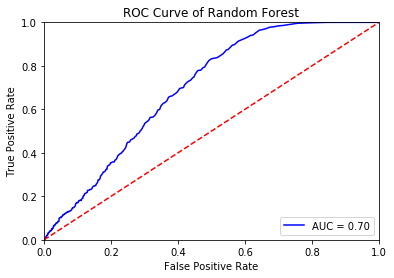

In [241]:
from sklearn.metrics import roc_curve,auc

y_scores = rf.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
#plot the ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
#axis label
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Random Forest')
plt.show()

In [239]:
from sklearn.metrics import classification_report,confusion_matrix

confusion=confusion_matrix(y_predict,y_test)
classifiction=classification_report(y_predict,y_test)

print('Confusion matrix:\n',confusion)
print('Classifiction report:\n',classifiction)

Confusion matrix:
 [[2966  455]
 [ 137   42]]
Classifiction report:
               precision    recall  f1-score   support

           0       0.96      0.87      0.91      3421
           1       0.08      0.23      0.12       179

    accuracy                           0.84      3600
   macro avg       0.52      0.55      0.52      3600
weighted avg       0.91      0.84      0.87      3600



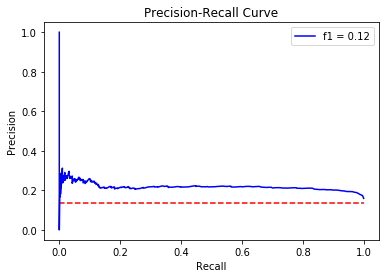

In [242]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

precision, recall, _ = precision_recall_curve(y_test, y_scores[:, 1])
f1, auc = f1_score(y_test, y_predict), auc(recall, precision)
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--',c='r')
plt.plot(recall, precision,c='b',label = 'f1 = %0.2f' % f1)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc = 'upper right')
plt.title('Precision-Recall Curve')
# show the plot
plt.show()

The AUC= 0.7, which is acceptable. The f1 score is low, because it is unbalanced dataset. The model can be used to predict the possible user adoption. 

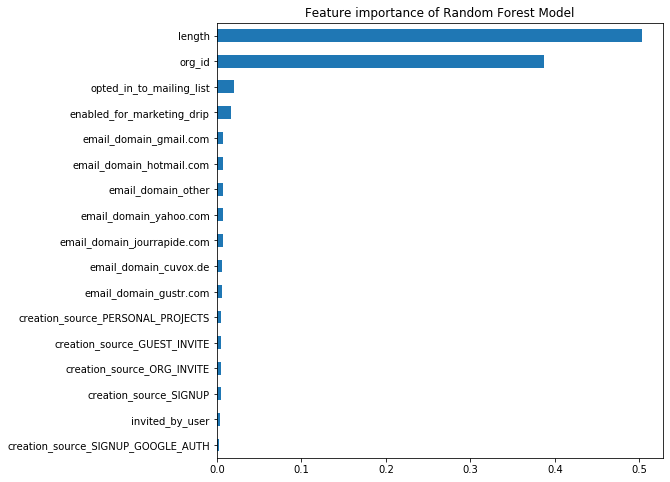

In [243]:
# Random Forest Feature Importance

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=True)

importances.plot(kind='barh',figsize=(8,8))
plt.title("Feature importance of Random Forest Model")
plt.show()

As we can see above, the length of time using the software and the organization (group of users) they belong to are the major impotant features. 